In [57]:
import numpy as np
import torch_geometric
print(torch_geometric.__version__)

def calculate_force(particle1, particle2):
    dx = particle2[0] - particle1[0]
    dy = particle2[1] - particle1[1]
    r_squared = dx**2 + dy**2
    
    if r_squared == 0:
        return [0, 0]  # Avoid division by zero
    
    force_magnitude = particle1[2] * particle2[2] / r_squared
    force_x = force_magnitude * dx / np.sqrt(r_squared)
    force_y = force_magnitude * dy / np.sqrt(r_squared)
    
    return [force_x, force_y]

def generate_particle_dataset(num_points):
    dataset = []
    min_distance = 0.5  # Minimum distance constraint
    
    for i in range(num_points):
        # Generate the points in different locations to unbias learning
        x_beginning = None
        y_beginning = None
        if i % 4 == 0:
            x_beginning = 0
            y_beginning = 0
        elif i % 4 == 1:
            x_beginning = 1
            y_beginning = 0
        elif i % 4 == 2:
            x_beginning = 0
            y_beginning = 1
        else:
            x_beginning = 1
            y_beginning = 1

        data_point = []
        positions = []

        # Generate 3 particles with unique positions separated by at least 0.1
        for _ in range(3):
            while True:
                x = np.random.uniform(x_beginning, x_beginning + 1)
                y = np.random.uniform(y_beginning, y_beginning + 1)
                position = (x, y)

                # Check distance against all existing particles
                if all(np.sqrt((x - px)**2 + (y - py)**2) >= min_distance for px, py in positions):
                    positions.append(position)
                    break
            
            mass = np.random.uniform(1, 6)
            particle = [x, y, mass, [0, 0]]  # [x, y, mass, [force_x, force_y]]
            data_point.append(particle)
        
        # Calculate forces
        for i in range(3):
            for j in range(3):
                if i != j:
                    force = calculate_force(data_point[i], data_point[j])
                    data_point[i][3][0] += force[0]
                    data_point[i][3][1] += force[1]
        
        dataset.append(data_point)
    
    return dataset

# Generate a dataset with 100 data points
num_points = 10000
particle_dataset = generate_particle_dataset(num_points)

# Print the first few data points as an example
for i, data_point in enumerate(particle_dataset[:3]):
    print(f"Data point {i + 1}:")
    for j, particle in enumerate(data_point):
        print(f"  Particle {j + 1}: [x = {particle[0]:.6f}, y = {particle[1]:.6f}, mass = {particle[2]:.4f}, force = [{particle[3][0]:.6e}, {particle[3][1]:.6e}]]")
    print()

2.5.3
Data point 1:
  Particle 1: [x = 0.706294, y = 0.223250, mass = 4.7638, force = [-4.960142e+01, 3.072559e+01]]
  Particle 2: [x = 0.277596, y = 0.844327, mass = 5.0034, force = [1.861239e+01, -5.362477e+01]]
  Particle 3: [x = 0.086443, y = 0.134025, mass = 2.1481, force = [3.098903e+01, 2.289918e+01]]

Data point 2:
  Particle 1: [x = 1.589965, y = 0.233185, mass = 3.0211, force = [-4.331020e+01, 2.242402e+01]]
  Particle 2: [x = 1.321363, y = 0.785277, mass = 2.0831, force = [-8.090592e+00, -3.960564e+01]]
  Particle 3: [x = 1.045886, y = 0.345182, mass = 3.7547, force = [5.140079e+01, 1.718162e+01]]

Data point 3:
  Particle 1: [x = 0.025642, y = 1.120728, mass = 4.8282, force = [7.419466e+00, 3.399411e+01]]
  Particle 2: [x = 0.710946, y = 1.654384, mass = 1.1433, force = [-1.193255e+01, -3.704218e+00]]
  Particle 3: [x = 0.060094, y = 1.738010, mass = 2.3389, force = [4.513085e+00, -3.028990e+01]]



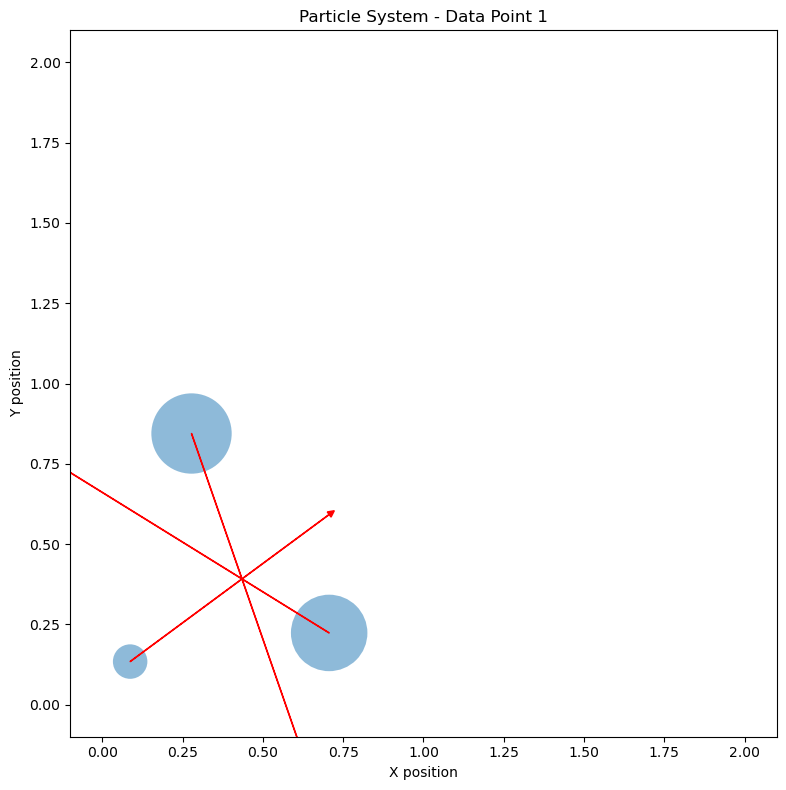

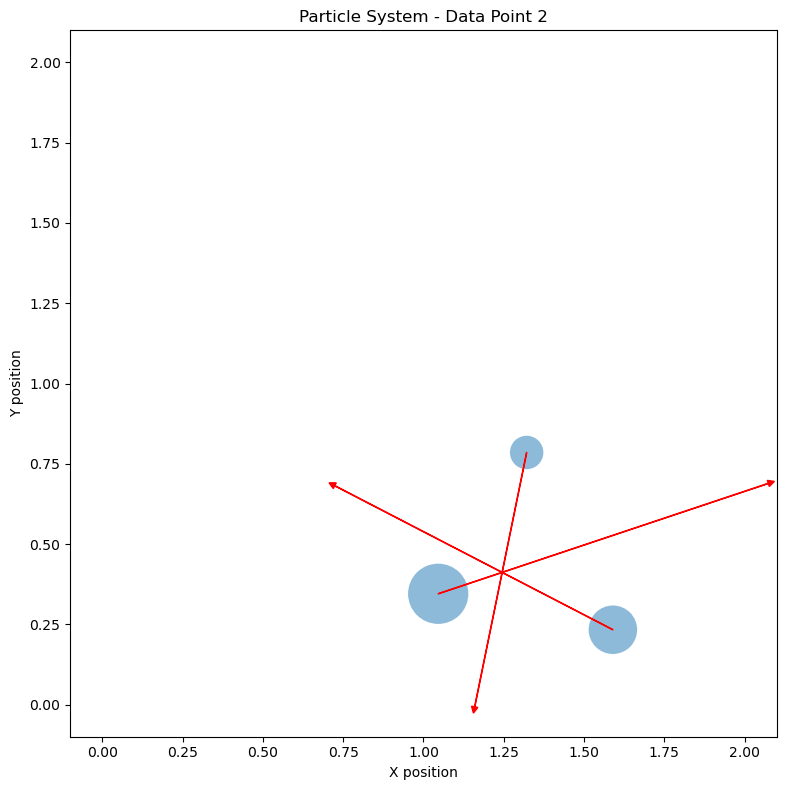

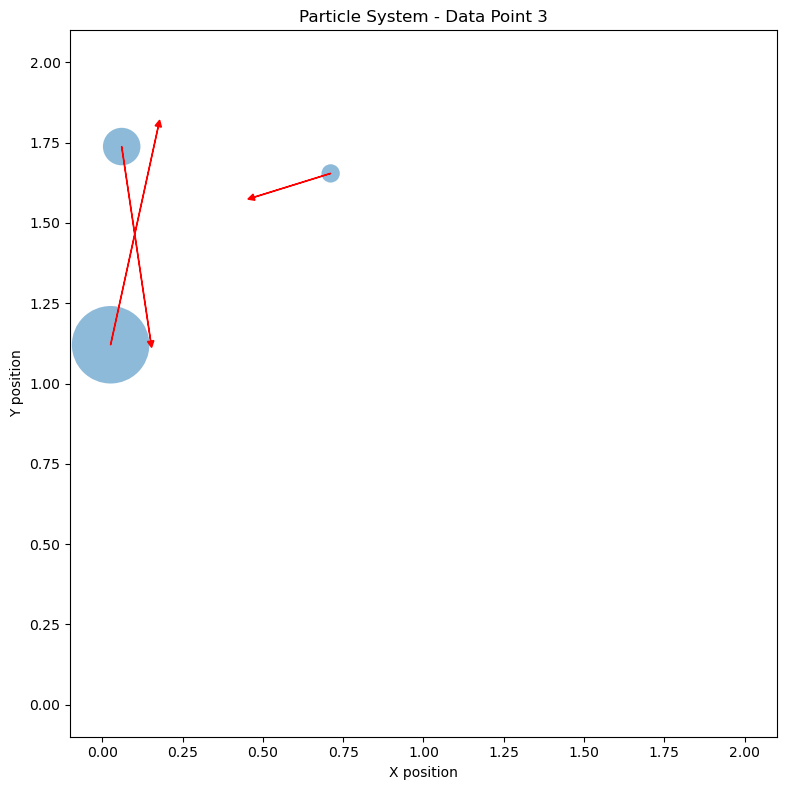

In [58]:
import matplotlib.pyplot as plt
import numpy as np

def plot_particle_system(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    
    # Find the maximum mass for scaling
    max_mass = max(particle[2] for particle in data_point)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = mass / 40  # Scale size relative to maximum mass
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                    head_width=0.02, head_length=0.02, fc='r', ec='r')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Assuming particle_dataset is already generated
# Plot the first 3 data points
for i, data_point in enumerate(particle_dataset[:3]):
    plot_particle_system(data_point, i+1)

In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Data

class EdgeModel(MessagePassing):
    def __init__(self):
        super(EdgeModel, self).__init__(aggr='add')  # "Add" aggregation.
        self.mlp = nn.Sequential(
            nn.Linear(6, 64),  # 6 = 2 (pos) + 1 (mass) for each particle
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 2)  # Output 2D force
        )

    def forward(self, x, edge_index):
        return self.propagate(edge_index, x=x)

    def message(self, x_i, x_j):
        tmp = torch.cat([x_i, x_j], dim=1)  # Concatenate features of both nodes
        out = self.mlp(tmp)
        return out

class NodeModel(nn.Module):
    def __init__(self):
        super(NodeModel, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(5, 32),  # 5 = 2 (pos) + 1 (mass) + 2 (aggregated force)
            nn.ReLU(),
            nn.Linear(32, 5),
            nn.ReLU(),
            nn.Linear(5, 2)  # Output 2D force
        )

    def forward(self, x, edge_index, edge_attr):
        # The edge attributes have already been added when the Message Passing layer was
        # applied. Simply concatenate them with the node's features
        out = torch.cat([x, edge_attr], dim=1)
        # Not using the mlp for now
        return edge_attr

class ParticleGNN(nn.Module):
    def __init__(self):
        super(ParticleGNN, self).__init__()
        self.edge_model = EdgeModel()
        self.node_model = NodeModel()

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        
        # Edge Model
        edge_attr = self.edge_model(x, edge_index)
        
        # Node Model
        out = self.node_model(x, edge_index, edge_attr)
        
        return out

# Create a sample input
def create_sample_data(num_particles=3):
    x = torch.rand(num_particles, 3)  # [x, y, mass] for each particle
    edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                               [1, 2, 0, 2, 0, 1]], dtype=torch.long)
    data = Data(x=x, edge_index=edge_index)
    return data

# Initialize the model
model = ParticleGNN()

# Create sample data
data = create_sample_data()
print(data)
print("node info: ", data.x)

# Forward pass
output = model(data)

print("Input:")
print(data.x)
print("\nOutput (forces):")
print(output)


Data(x=[3, 3], edge_index=[2, 6])
node info:  tensor([[0.1972, 0.3292, 0.1275],
        [0.4035, 0.7828, 0.7454],
        [0.4690, 0.8282, 0.6220]])
Input:
tensor([[0.1972, 0.3292, 0.1275],
        [0.4035, 0.7828, 0.7454],
        [0.4690, 0.8282, 0.6220]])

Output (forces):
tensor([[-0.2659, -0.1630],
        [-0.2533, -0.1829],
        [-0.2521, -0.1822]], grad_fn=<ScatterAddBackward0>)


In [60]:
x_dataset = []
y_dataset = []
edge_index = torch.tensor([[0, 0, 1, 1, 2, 2],
                           [1, 2, 0, 2, 0, 1]], dtype=torch.long)
for data_point in particle_dataset:
    x = torch.tensor([particle[:3] for particle in data_point], dtype=torch.float32)
    y = torch.tensor([particle[3] for particle in data_point], dtype=torch.float32)
    x_dataset.append(Data(x=x, edge_index=edge_index))
    y_dataset.append(y)


for particle in particle_dataset[:2]:
    print(particle)

print("\n")

for x in x_dataset[:2]:
    print(x.x)

print("\n")

for y in y_dataset[:2]:
    print(y)

[[0.7062938078633202, 0.2232501980037772, 4.763822024613333, [-49.60142271718167, 30.725586795147784]], [0.2775964207727937, 0.8443273893449335, 5.0033986706236, [18.612394591142206, -53.62476876282379]], [0.08644330752650964, 0.13402491176487286, 2.1480911932164526, [30.989028126039464, 22.89918196767601]]]
[[1.5899653831579919, 0.2331845623781924, 3.0210632667773125, [-43.31019895954265, 22.424023969254133]], [1.3213627219242305, 0.7852765447413806, 2.083061258669641, [-8.090591821248324, -39.60564412137052]], [1.045886416461706, 0.3451823363809532, 3.754743933331811, [51.40079078079098, 17.18162015211638]]]


tensor([[0.7063, 0.2233, 4.7638],
        [0.2776, 0.8443, 5.0034],
        [0.0864, 0.1340, 2.1481]])
tensor([[1.5900, 0.2332, 3.0211],
        [1.3214, 0.7853, 2.0831],
        [1.0459, 0.3452, 3.7547]])


tensor([[-49.6014,  30.7256],
        [ 18.6124, -53.6248],
        [ 30.9890,  22.8992]])
tensor([[-43.3102,  22.4240],
        [ -8.0906, -39.6056],
        [ 51.4008,  1

Using device: cuda
Epoch [1/100], Loss: 558.4962, Learning Rate: 0.0200000000
Epoch [2/100], Loss: 126.3369, Learning Rate: 0.0200000000
Epoch [3/100], Loss: 61.8451, Learning Rate: 0.0200000000
Epoch [4/100], Loss: 40.9761, Learning Rate: 0.0200000000
Epoch [5/100], Loss: 32.2963, Learning Rate: 0.0200000000
Epoch [6/100], Loss: 27.9992, Learning Rate: 0.0200000000
Epoch [7/100], Loss: 25.6182, Learning Rate: 0.0200000000
Epoch [8/100], Loss: 19.6399, Learning Rate: 0.0200000000
Epoch [9/100], Loss: 18.3314, Learning Rate: 0.0200000000
Epoch [10/100], Loss: 16.0530, Learning Rate: 0.0180000000
Epoch [11/100], Loss: 13.3045, Learning Rate: 0.0180000000
Epoch [12/100], Loss: 12.8068, Learning Rate: 0.0180000000
Epoch [13/100], Loss: 14.2552, Learning Rate: 0.0180000000
Epoch [14/100], Loss: 13.5678, Learning Rate: 0.0180000000
Epoch [15/100], Loss: 12.4424, Learning Rate: 0.0180000000
Epoch [16/100], Loss: 13.4867, Learning Rate: 0.0180000000
Epoch [17/100], Loss: 11.5407, Learning Rate

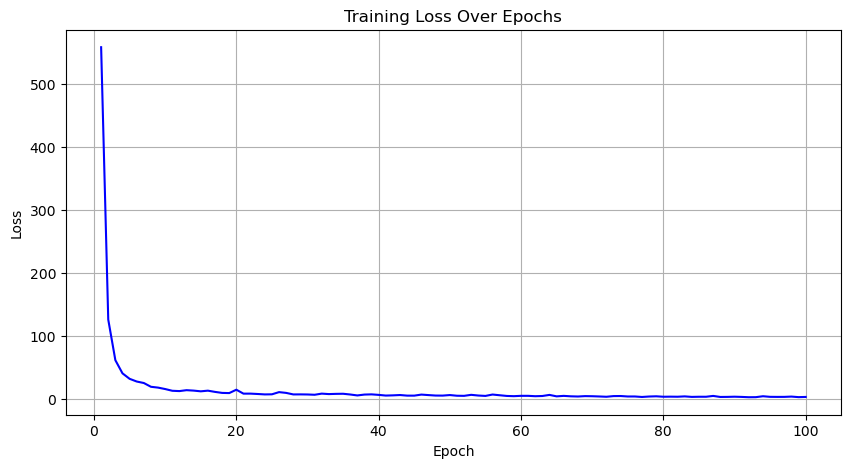

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from torch_geometric.loader import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move the model to the device
model = model.to(device)

# Create a custom dataset that combines x (graph data) and y (labels)
class GraphDataset(Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data  # List of torch_geometric.data.Data objects
        self.y_data = y_data  # Corresponding labels

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        x = self.x_data[idx]  # Get the graph data
        y = self.y_data[idx]  # Get the corresponding label
        x.y = y  # Assign the label to the graph data object
        return x

# Initialize the custom dataset
dataset = GraphDataset(x_dataset, y_dataset)

# Train-test split
train_size = 0.8  # Define the proportion of training data
x_train, x_test, y_train, y_test = train_test_split(
    dataset.x_data, dataset.y_data, train_size=train_size, random_state=42
)

# Create training and testing datasets
train_dataset = GraphDataset(x_train, y_train)
test_dataset = GraphDataset(x_test, y_test)

# Use PyTorch Geometric DataLoader to load data in batches
batch_size = 64  # Set your desired batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define a loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.02)

# Define a learning rate scheduler
scheduler = StepLR(optimizer, step_size=10, gamma=0.9)  # Reduce LR by factor of gamma every step_size epochs

# Training loop
num_epochs = 100  # Define the number of epochs
loss_values = []  # List to store loss values for each epoch

for epoch in range(num_epochs):
    model.train()
    
    # Training phase
    epoch_loss = 0.0  # Initialize epoch loss
    for batch in train_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Accumulate epoch loss
        epoch_loss += loss.item()
    
    # Average loss for the epoch
    avg_epoch_loss = epoch_loss / len(train_loader)
    loss_values.append(avg_epoch_loss)  # Store the average loss
    
    # Update the learning rate
    scheduler.step()  # Call the scheduler step at the end of each epoch
    
    # Print loss for every epoch
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}, Learning Rate: {scheduler.get_last_lr()[0]:.10f}')

print("Training complete!")

# Plot the loss values
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), loss_values, color='b', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.show()

In [62]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to store test loss and metrics
test_loss = 0.0  # Total loss over the test set
test_samples = 0  # Total number of samples

# Disable gradient computation for evaluation
with torch.no_grad():
    for batch in test_loader:
        # Move data to the device
        batch = batch.to(device)
        
        # Forward pass
        output = model(batch)
        
        # Compute loss
        loss = criterion(output, batch.y)
        test_loss += loss.item() * batch.num_graphs  # Sum up batch loss, multiplied by number of graphs in the batch
        test_samples += batch.num_graphs  # Accumulate the total number of graphs

# Calculate the average test loss
avg_test_loss = test_loss / test_samples

print(f'Average Test Loss: {avg_test_loss:.4f}')

Average Test Loss: 4.8392


In [63]:
# Ensure the model is in evaluation mode
model.eval()

# Move the model to the device if not already done
model = model.to(device)

# Prepare to store predictions
predicted_forces = []

# Iterate through the dataset to predict forces
for x in x_dataset:
    # Move data to the device
    x = x.to(device)
    
    # Make predictions
    with torch.no_grad():
        output = model(x)
        predicted_forces.append(output.cpu().numpy())

# Convert predicted forces to a format suitable for plotting
predicted_particle_dataset = []
for i, data_point in enumerate(particle_dataset[:6]):
    predicted_data_point = []
    for j, particle in enumerate(data_point):
        predicted_force = predicted_forces[i][j]  # Get predicted force
        particle_with_predicted_force = [particle[0], particle[1], particle[2], predicted_force.tolist()]
        predicted_data_point.append(particle_with_predicted_force)
    predicted_particle_dataset.append(predicted_data_point)

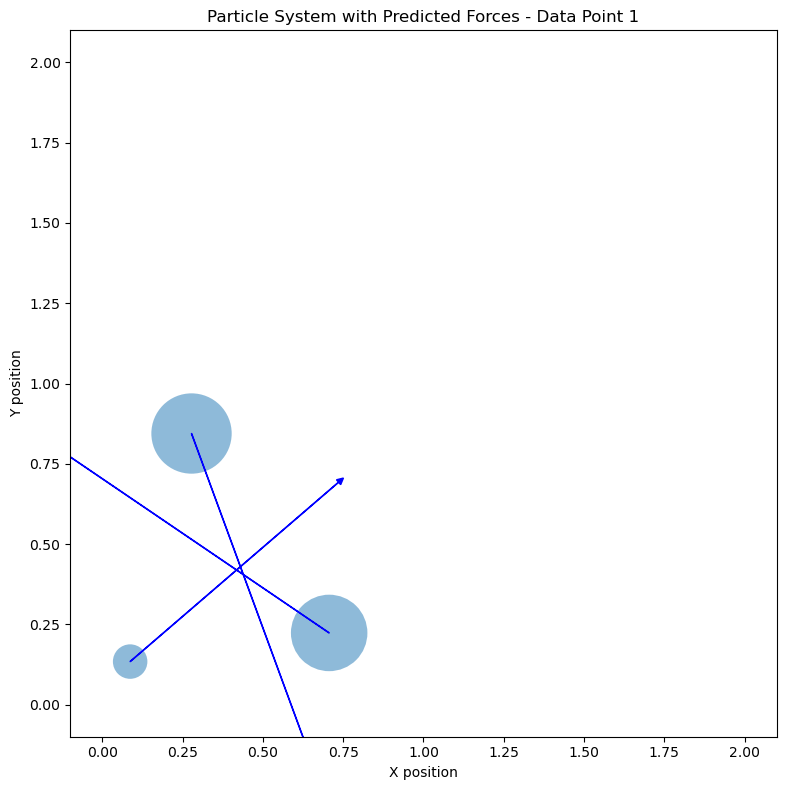

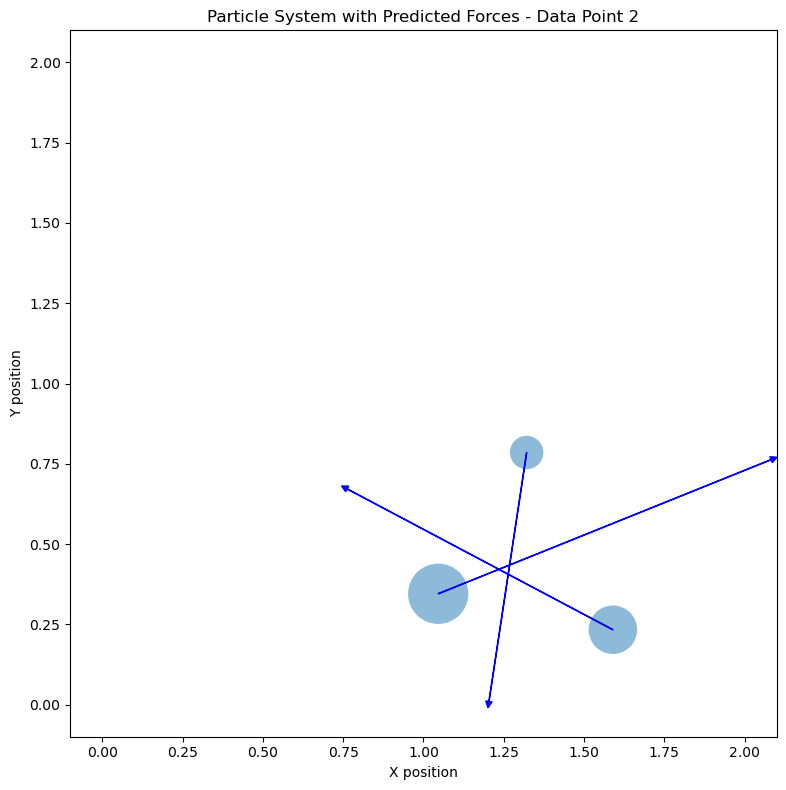

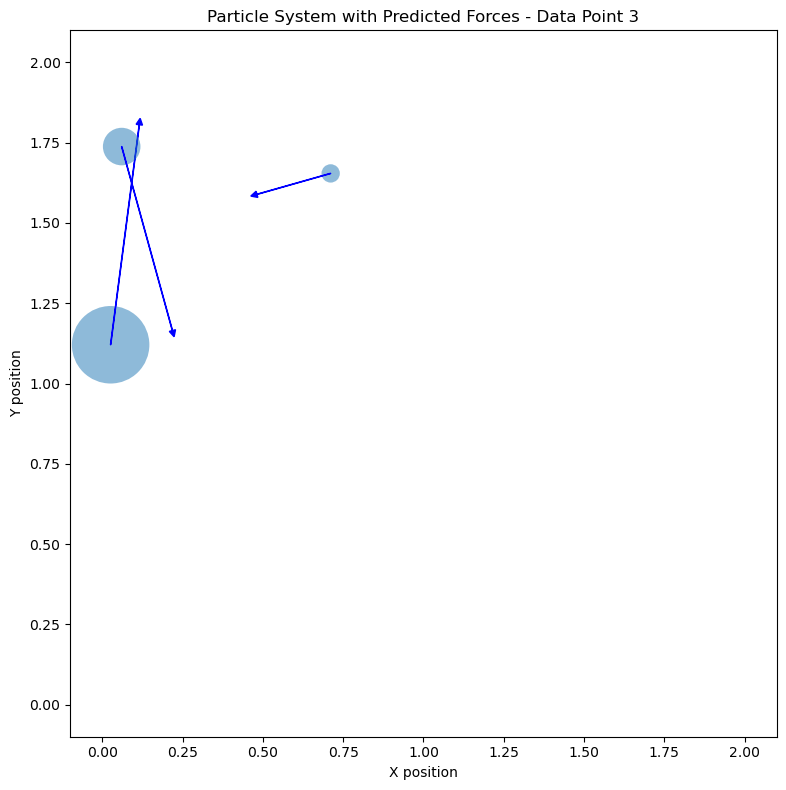

In [68]:
def plot_predicted_forces(data_point, index):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    # Set plot limits
    ax.set_xlim(-0.1, 2.1)
    ax.set_ylim(-0.1, 2.1)
    
    # Plot particles and forces
    for particle in data_point:
        x, y, mass, force = particle
        
        # Plot particle as a circle
        radius = mass / 40  # Scale radius
        circle = plt.Circle((x, y), radius=radius, fill=True, alpha=0.5)
        ax.add_artist(circle)
        
        # Plot predicted force arrow
        force_x, force_y = force
        # Scale arrow length
        scale = 0.02
        ax.arrow(x, y, force_x * scale, force_y * scale, 
                 head_width=0.02, head_length=0.02, fc='b', ec='b')
    
    ax.set_aspect('equal')
    ax.set_title(f'Particle System with Predicted Forces - Data Point {index}')
    ax.set_xlabel('X position')
    ax.set_ylabel('Y position')
    
    plt.tight_layout()
    plt.show()

# Plot the predicted forces for the first 3 data points
for i, data_point in enumerate(predicted_particle_dataset[:3]):
    plot_predicted_forces(data_point, i + 1)

In [65]:
# Organize the data for PySR
input_data = []
predicted_forces = []
for i, data_point in enumerate(particle_dataset[:1000]):
    for j in range(0, 3):
        for k in range(0, 3):
            if j != k:
                particleA = data_point[j][:3]
                particleB = data_point[k][:3]
                input_tensor = torch.tensor(particleA + particleB, dtype=torch.float32)
                input_data.append(input_tensor)
                predicted_forces.append(model.edge_model.mlp(input_tensor.cuda()))

# Convert lists to NumPy arrays
input_data = np.vstack(input_data)
predicted_forces = np.vstack([tensor.cpu().detach().numpy() for tensor in predicted_forces])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


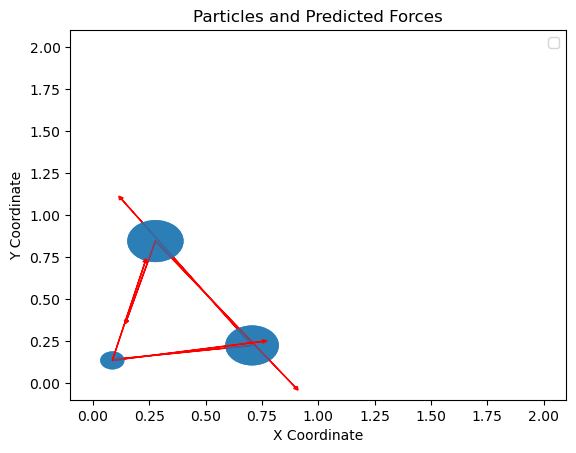

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


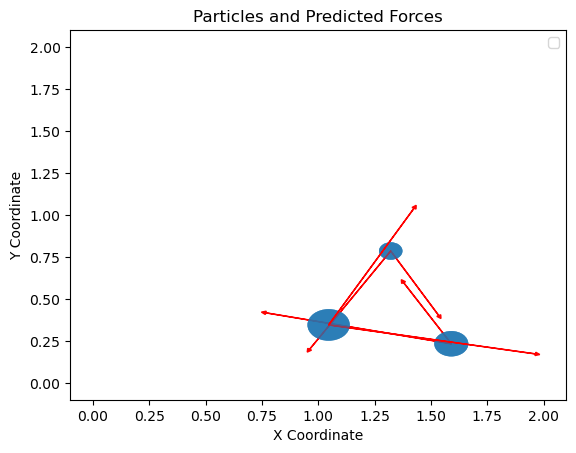

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


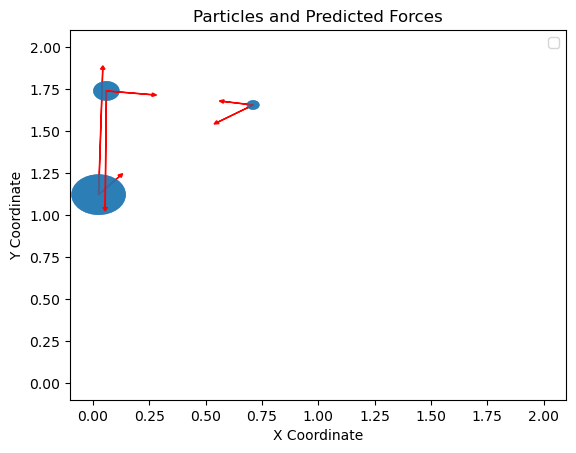

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


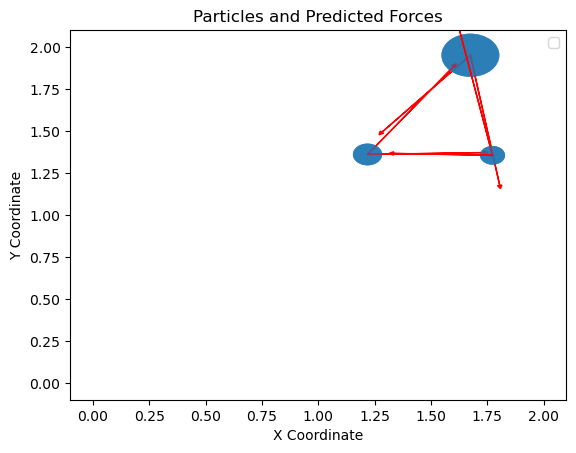

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


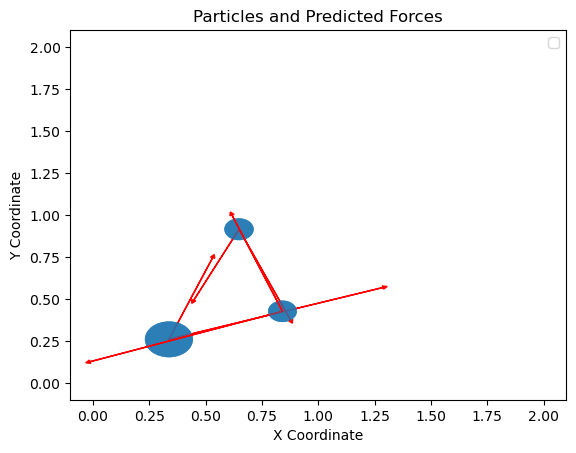

In [69]:
# Sample input data and predicted forces from the provided examples
n_samples = 30
input_data_sample = input_data[:n_samples]  # Extracting the first n_samples samples
predicted_forces_sample = predicted_forces[:n_samples]  # Extracting the first n_samples predicted forces


for k in range(0, len(input_data_sample), 6):
    # Create a new figure for each plot
    plt.figure()

    for i in range(k, k + 6):

        # Set plot limits
        plt.xlim(-0.1, 2.1)
        plt.ylim(-0.1, 2.1)

        # Extract particle data
        x1, y1, mass1, x2, y2, mass2 = input_data_sample[i]
        Fx, Fy = predicted_forces_sample[i]

        # Calculate the magnitude of the force
        force_magnitude = np.sqrt(Fx**2 + Fy**2)
        
        # Plot particles as a circles
        radius = mass1 / 40
        circle = plt.Circle((x1, y1), radius=radius, fill=True, alpha=0.5)
        plt.gca().add_artist(circle)
        radius = mass2 / 40
        circle = plt.Circle((x2, y2), radius=radius, fill=True, alpha=0.5)
        plt.gca().add_artist(circle)

        # Scale down the force arrow for visibility
        scale_factor = 0.1  # Adjust this value to change the arrow size

        # Draw force vector on Particle A (scaled down)
        plt.arrow(x1, y1, Fx / 40, Fy / 40, 
                head_width=0.02, head_length=0.02, fc='r', ec='r')

    # Set plot properties
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(f'Particles and Predicted Forces')
    plt.legend()
    plt.show()

In [74]:
# Add a new column to the input data with the distances between particles
distances = []
for i in range(len(input_data)):
    x1, y1, mass1, x2, y2, mass2 = input_data[i]
    distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    distances.append(distance)

# Convert distances to a numpy array and add as a new column
distances = np.array(distances).reshape(-1, 1)
input_data_with_distances = np.hstack((input_data, distances))

ValueError: too many values to unpack (expected 6)

In [75]:
from pysr import PySRRegressor

model = PySRRegressor(
    niterations=40,
    binary_operators=["+", "-","*", "/"],
    unary_operators=["sqrt"],
)

model.fit(input_data_with_distances[:5000], predicted_forces[:5000])

/home/polg24/anaconda3/envs/tfg_env/lib/python3.12/site-packages/pysr/sr.py:2582: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.550e+03
Head worker occupation: 54.8%. This is high, and will prevent efficient resource usage. Increase `ncycles_per_iteration` to reduce load on head worker.
Progress: 12 / 1200 total iterations (1.000%)
Best equations for output 1
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
2           5.836e+02  7.971e+00  y₀ = sqrt(x₃)
3           5.683e+02  2.654e-02  y₀ = x₃ * x₅
5           5.598e+02  7.522e-03  y₀ = (x₃ * x₃) * x₅
7           5.188e+02  3.806e-02  y₀ = 0.2638 - (x₅ * (x₀ - x₃))
9           3.450e+02  2.039e-01  y₀ = x₀ - (((x₀ - x₃) * x₅) * x₅)
14          3.399e+02  2.963e-03  y₀ = ((x₀ + (((x₀ * sqrt(2.429)) - x₃) - x₃)) / -0.4359) * x₅
15          1.219e+02  1.025e+00  y₀ = 0.2638 - (((x₂ * (1.3614 - -0.22571)) / x₆) * (x₅ * (x₀ -...
                                   x₃)))
16          8.383e+01  3.745e-01  y₀ = 0.53702 - (((1.